In [1]:
import torch
from transformers import BertModel
import numpy as np
import time

############# code changes ###############
import intel_extension_for_pytorch as ipex
############# code changes ###############

/home/u105696/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

vocab_size = model.config.vocab_size
batch_size = 16
seq_length = 512

data = torch.randint(vocab_size, size=[batch_size, seq_length])
print(data.size())

num_times = 50
warmup_rounds = 20
latency_list = []

for i in range(num_times):
    time_start = time.time()
    model(data)
    if i >= warmup_rounds:
        latency_list.append(time.time() - time_start)

fp32_inference_time = np.mean(latency_list)
print("Inference time for FP32 took %.3f seconds" %(fp32_inference_time))


torch.Size([16, 512])
Inference time for FP32 took 0.662 seconds


In [3]:
#################### code changes ####################  
model_bf16 = ipex.optimize(model, dtype=torch.bfloat16)
#model = ipex._optimize_transformers(model.eval(), dtype=torch.bfloat16, inplace=True)
######################################################  
latency_list = []
with torch.no_grad(), torch.cpu.amp.autocast():
    for i in range(num_times):
        time_start = time.time()
        model_bf16(data)
        if i >= warmup_rounds:
            latency_list.append(time.time() - time_start)

bf16_inference_time = np.mean(latency_list)
print("Inference time for BF16 took %.3f seconds" %(bf16_inference_time))

/home/common/miniconda3/envs/pytorch_xpu/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:522: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/home/common/miniconda3/envs/pytorch_xpu/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:527: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")


Inference time for BF16 took 0.144 seconds


In [4]:
with torch.no_grad(), torch.cpu.amp.autocast():
    d = torch.randint(vocab_size, size=[batch_size, seq_length])
    model = torch.jit.trace(model_bf16, (d,), check_trace=False, strict=False)
    model = torch.jit.freeze(model)
    latency_list = []
    for i in range(num_times):
        time_start = time.time()
        model(data)
        if i >= warmup_rounds:
            latency_list.append(time.time() - time_start)

torchscript_inference_time = np.mean(latency_list)
print("Inference time for Torchscript took %.3f seconds" %(torchscript_inference_time))
print("Execution finished")

Inference time for Torchscript took 0.107 seconds
Execution finished


In [12]:
"""
Prints out results and displays figures summarizing output.
"""
NUM_SAMPLES = batch_size
def summarize_results(modelName="", results=None):
    """
    Input parameters
        modelName: a str representing the name of the model
        results: a dict with the run case and its corresponding time in seconds
    Return value
        None
    """

    # Inference time results
    print("\nSummary for %s (%d samples)" %(modelName, NUM_SAMPLES))
    for key in results.keys():
        print("%s inference time: %.3f seconds" %(key, results[key]))

    # Create bar chart with inference time results
    plt.figure()
    plt.title("%s Inference Time (%d samples)" %(modelName, NUM_SAMPLES))
    plt.xlabel("Run Case")
    plt.ylabel("Inference Time (seconds)")
    plt.bar(results.keys(), results.values())

    # Calculate speedup when using AMX
    print("\n")
    bf16_speedup = results["FP32"] / results["BF16"]
    print("BF16 with AMX is %.2fX faster than FP32" %bf16_speedup)
    torchscript_speedup = results["FP32"] / results["TorchScript"]
    print("Torchscript is %.2fX faster than FP32" %torchscript_speedup)
    print("\n\n")

    # Create bar chart with speedup results
    plt.figure()
    plt.title("%s AMX BF16 Speedup over FP32" %modelName)
    plt.xlabel("Run Case")
    plt.ylabel("Speedup")
    plt.bar(results.keys(), 
        [1, bf16_speedup, torchscript_speedup]
    )

Defaulting to user installation because normal site-packages is not writeable

Summary for BERT (16 samples)
FP32 inference time: 0.662 seconds
BF16 inference time: 0.144 seconds
TorchScript inference time: 0.107 seconds


BF16 with AMX is 4.59X faster than FP32
Torchscript is 6.18X faster than FP32





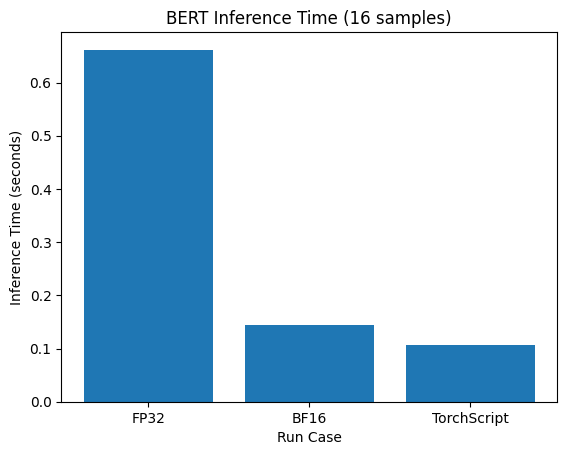

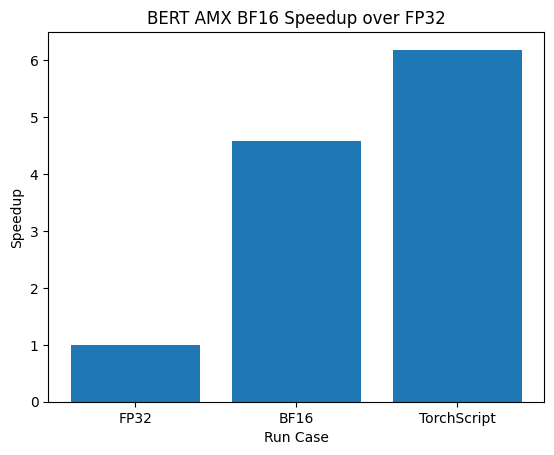

In [13]:
# Summarize and display results
!pip install matplotlib
import matplotlib.pyplot as plt
results_bert = {
        "FP32": fp32_inference_time,
        "BF16": bf16_inference_time,
        "TorchScript": torchscript_inference_time
    }
summarize_results("BERT", results_bert)
plt.show()